In this note, we want to mimic measure pulse default of IBM system

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import *

import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')

IBMProvider.save_account('b751d05f9c3522f9d46a851e2830dfa0d6087643fcdda1588b781e2f349cbaa8c6d7b1dbec1ec3262857523289bb385ee8ad7b86a83c045ca69aba6b1bc4b3d8', overwrite=True)
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

In [26]:
def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    score = LDA_012.score(IQ_012_test, state_012_test)
    return LDA_012, score

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = discrim_data[0]
    one_data = discrim_data[1]
    two_data = discrim_data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [4]:
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [5]:
qubit = 0
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
NUM_SHOTS = 2048
scale_factor = 1e-14
GHz = 1e9
MHz = 1e6

In [6]:
q0_freq = backend_defaults.qubit_freq_est[0]  # Hz
q0_meas_freq = backend_defaults.meas_freq_est[0]  # Hz

print("DriveChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_freq / GHz))
print("MeasureChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_meas_freq / GHz))

DriveChannel(0) defaults to a modulation frequency of 4.721881790189039 GHz.
MeasureChannel(0) defaults to a modulation frequency of 7.175428524047673 GHz.


In [9]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.abs(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

In [11]:
dur12 = 160
sig12 = dur12/4
amp12 = 0.2370445388186373

dur01 = 120
sig01 = dur01/4
amp01 = 0.19854631022723826

In [13]:
def r12(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(12)}$') as r12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur12,
                                      amp=amp12*theta/np.pi,
                                      sigma=sig12,
                                      name=r'$X_{\pi/2}^{(12)}$'), drive_chan)

    return r12_pulse
xpi12 = r12(pi, 0)

We use this schedule to explore measure pulse default of ibm

In [14]:
with pulse.build(backend=backend) as sched:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(0, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.measure(0)

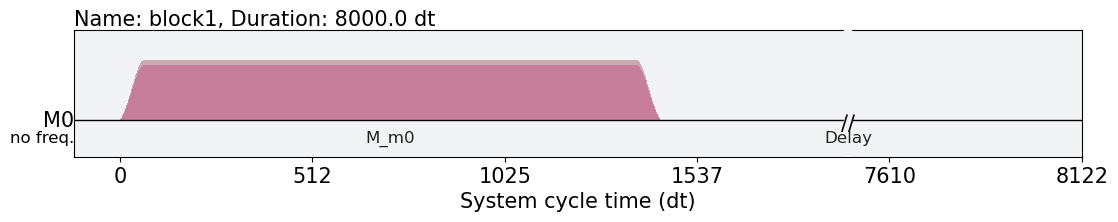

In [15]:
sched.draw()

In [17]:
meas_amp = Parameter("meas_amp")
with pulse.build(backend=backend, default_alignment='left') as meas_spec_default:
    meas_chan = pulse.measure_channel(qubit)
    #pulse.shift_frequency(shift_freq, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.acquire(1440, ac_chan, mem_chan)
    pulse.play(pulse.GaussianSquare(amp=meas_amp,
                                    duration=1440,
                                    sigma=32,
                                    width=1312,
                                    angle=0.7562388983610336), meas_chan)
    pulse.delay(6560, meas_chan)
Spec = Gate("Spectroscopy", 1, [meas_amp])

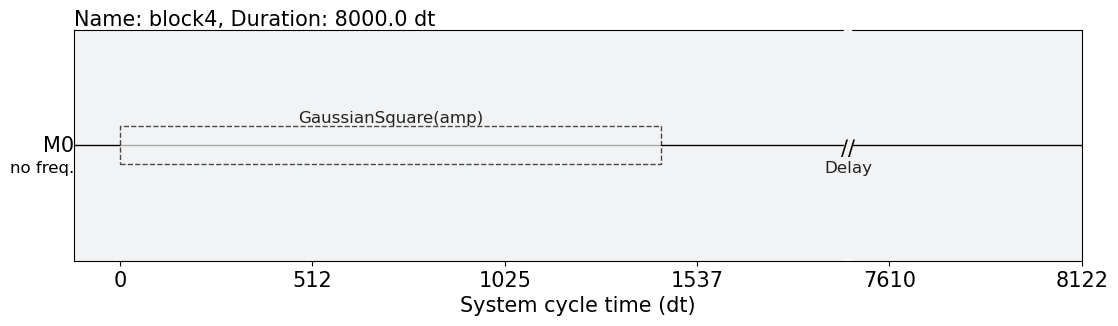

In [18]:
meas_spec_default.draw()

In [16]:
meas_amp_list = np.linspace(0, 1, 51)

In [21]:
Xpi01 = Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = Gate("$X_{\pi}^{12}$", 1, [])
Meas_gate = Gate("Measure", 1, [meas_amp])

In [22]:
qc_0 = QuantumCircuit(1, 1)
qc_0.append(Spec, [0])
qc_0.add_calibration(Spec, (0, ), meas_spec_default, [meas_amp])
spec_0_circs = [qc_0.assign_parameters({meas_amp: a}, inplace=False) for a in meas_amp_list]

In [24]:
qc_1 = QuantumCircuit(1, 1)
qc_1.x(0)
qc_1.append(Spec, [0])
qc_1.add_calibration(Spec, (0, ), meas_spec_default, [meas_amp])
spec_1_circs = [qc_1.assign_parameters({meas_amp: a}, inplace=False) for a in meas_amp_list]

In [25]:
qc_2 = QuantumCircuit(1, 1)
qc_2.x(0)
qc_2.append(Xpi12, [0])
qc_2.append(Spec, [0])
qc_2.add_calibration(Xpi12, (0, ), xpi12, [])
qc_2.add_calibration(Spec, (0, ), meas_spec_default, [meas_amp])
spec_2_circs = [qc_2.assign_parameters({meas_amp: a}, inplace=False) for a in meas_amp_list]

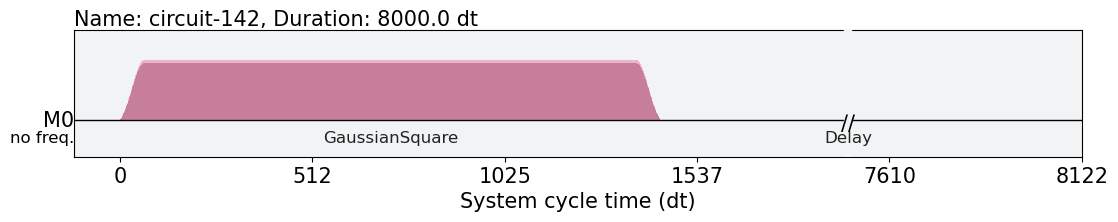

In [33]:
schedule(spec_0_circs[20], backend=backend).draw()

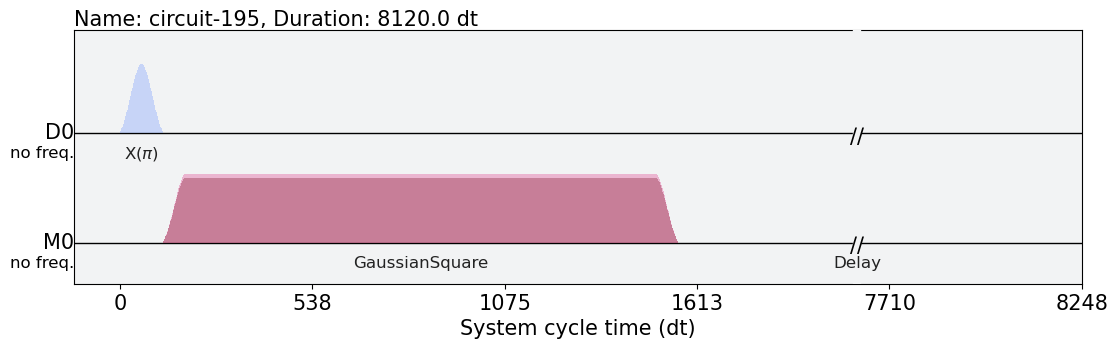

In [34]:
schedule(spec_1_circs[20], backend=backend).draw()

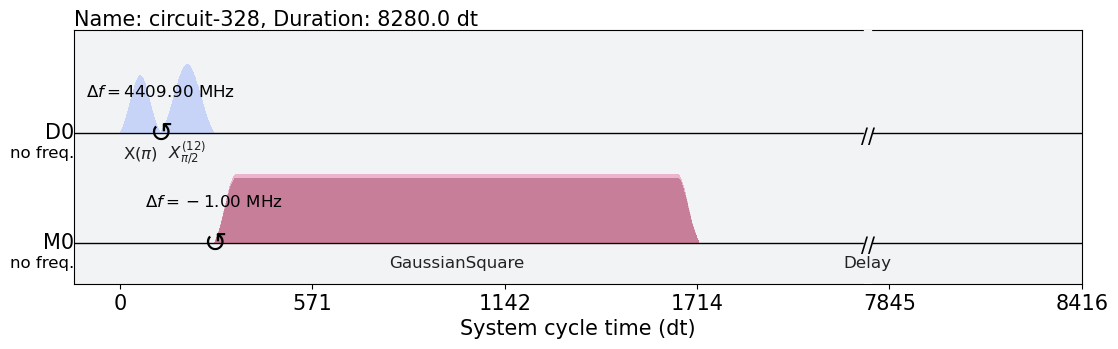

In [38]:
schedule(spec_2_circs[0], backend=backend).draw()

In [35]:
list_ids = []
spec_circs = [spec_0_circs, spec_1_circs, spec_2_circs]
#spec_circs = [spec_1_circs, spec_2_circs]
for circ in spec_circs:
    job = backend.run(circ, meas_level=1, meas_return='single', shots=4096)
    list_ids.append(job.job_id())
    
list_ids

['cnh13dxdpvjg008bgk4g', 'cnh13enxjp4g008mb3ag', 'cnh13fdxjp4g008mb3b0']

In [41]:
job = provider.backend.retrieve_job('cnh13dxdpvjg008bgk4g')

In [42]:
job_monitor(job)

Job Status: job has successfully run


In [17]:
#list_ids = ['cnbtrja0m2gg008c8hfg', 'cnbtrjt0m2gg008c8hg0', 'cnbtrkjrbhc0008j7ha0']
#list_ids = ['cnc6frfrbhc0008j8tjg', 'cnc6fs7hga30008f14yg', 'cnc6fsqrbhc0008j8tk0']
#list_ids = ['cngaptba1dag008p6pb0', 'cngapvbjq8rg0080r6g0', 'cngapw3njjq0008adt50']
list_ids = ['cnh13dxdpvjg008bgk4g', 'cnh13enxjp4g008mb3ag', 'cnh13fdxjp4g008mb3b0']
datas_average = []
datas_single = []
for id in list_ids:
    job = provider.backend.retrieve_job(id)
    datas_average.append(get_job_data(job, average=True))
    datas_single.append(get_job_data(job, average=False))

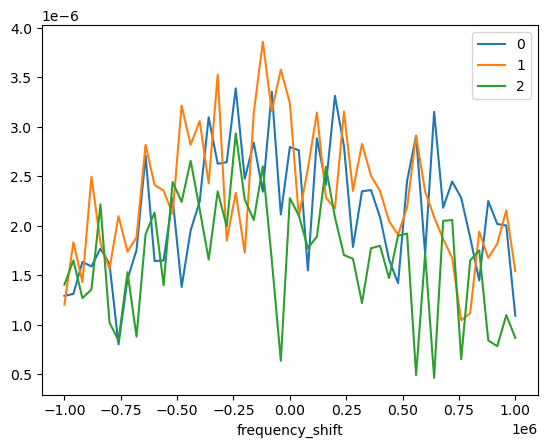

In [43]:
plt.plot(shift_frequencies, datas[0], label='0')
plt.plot(shift_frequencies, datas[1], label='1')
plt.plot(shift_frequencies, datas[2], label='2')
plt.xlabel('frequency_shift')
plt.legend()
#plt.savefig('spectro_test_1')

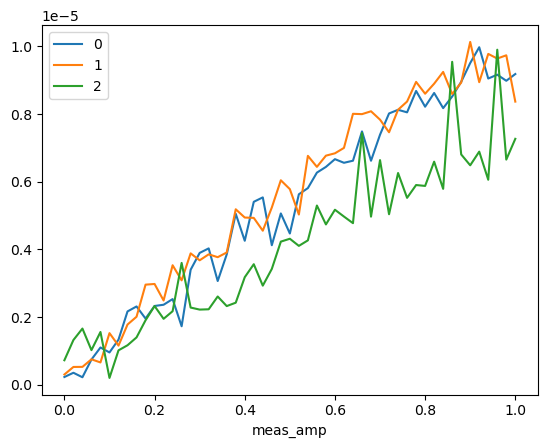

In [44]:
plt.plot(meas_amp_list, datas[0], label='0')
plt.plot(meas_amp_list, datas[1], label='1')
plt.plot(meas_amp_list, datas[2], label='2')
plt.xlabel('meas_amp')
plt.legend()

In [25]:
spec_circs_default = spec_ground.circuits()
schedule(spec_circs_default[50], backend=backend)

Schedule((0, ShiftFrequency(20000000, MeasureChannel(0))), (0, Acquire(960, AcquireChannel(0), MemorySlot(0))), (0, Play(GaussianSquare(duration=960, sigma=119.99999999999999, width=720.0, amp=1, angle=0), MeasureChannel(0))), name="circuit-374")

In [29]:
schedule(spec_circs[50], backend=backend)

Schedule((0, Play(Drag(duration=120, sigma=30, beta=-0.005467341849790603, amp=0.19792606011965364, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), (120, SetFrequency(4409901810.300696, DriveChannel(0))), (120, ShiftPhase(0, DriveChannel(0))), (120, Play(Gaussian(duration=160, sigma=40.0, amp=0.23743549524170637, angle=0, name='$X_{\pi/2}^{(12)}$'), DriveChannel(0), name='$X_{\pi/2}^{(12)}$')), (280, ShiftPhase(0, DriveChannel(0))), (280, ShiftFrequency(20000000.000000037, MeasureChannel(0))), (280, Acquire(960, AcquireChannel(0), MemorySlot(0))), (280, Play(GaussianSquare(duration=960, sigma=120, width=720, amp=1, angle=0), MeasureChannel(0))), name="circuit-427")

In [17]:
job = backend.run(spec_circs, meas_level=1, meas_return='single', shots=4096)

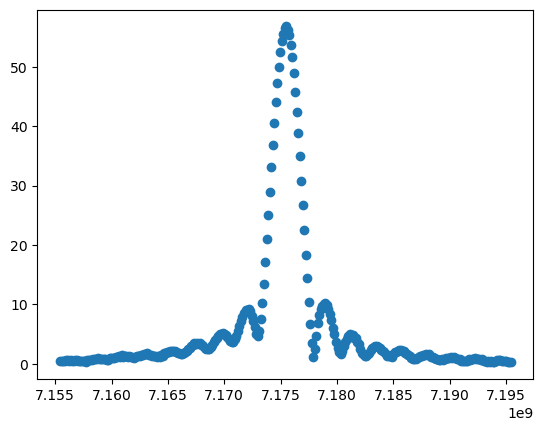

In [34]:
#plt.scatter(frequencies_0, data)
#plt.savefig("spec")
#cnay3740m2gg008c6960

In [18]:
job = provider.backend.retrieve_job("cnbtcy3xswgg0087g4c0")

In [19]:
data = get_job_data(job, average=True)

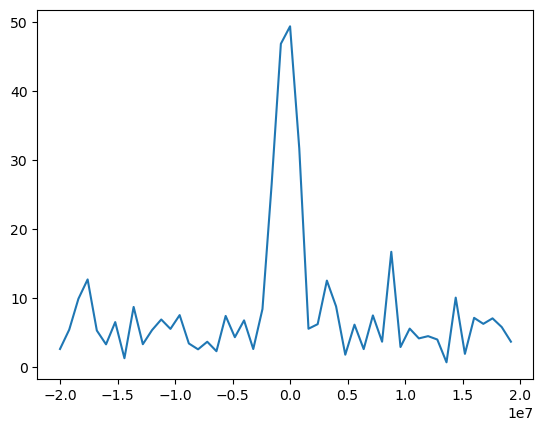

In [21]:
plt.plot(shift_frequencies, data)

In [45]:
datas_single = []
for id in list_ids:
    job = provider.backend.retrieve_job(id)
    data = get_job_data(job, average=False)
    datas_single.append(data)

In [18]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [55]:
one_datas = datas_single[0]
two_datas = datas_single[1]

In [19]:
zero_datas = datas_single[0]
one_datas = datas_single[1]
two_datas = datas_single[2]

In [20]:
zero_datas_aver = [np.average(data) for data in zero_datas]
one_datas_aver = [np.average(data) for data in one_datas]
two_datas_aver = [np.average(data) for data in two_datas]
plt.plot(shift_frequencies, np.real(np.array(zero_datas_aver)))
plt.plot(shift_frequencies, np.real(np.array(one_datas_aver)))
plt.plot(shift_frequencies, np.real(np.array(two_datas_aver)))

NameError: name 'shift_frequencies' is not defined

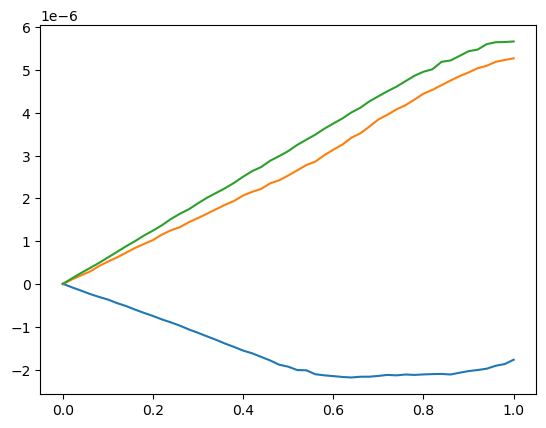

In [52]:
zero_datas_aver = [np.average(data) for data in zero_datas]
one_datas_aver = [np.average(data) for data in one_datas]
two_datas_aver = [np.average(data) for data in two_datas]
plt.plot(meas_amp_list, np.real(np.array(zero_datas_aver)))
plt.plot(meas_amp_list, np.real(np.array(one_datas_aver)))
plt.plot(meas_amp_list, np.real(np.array(two_datas_aver)))

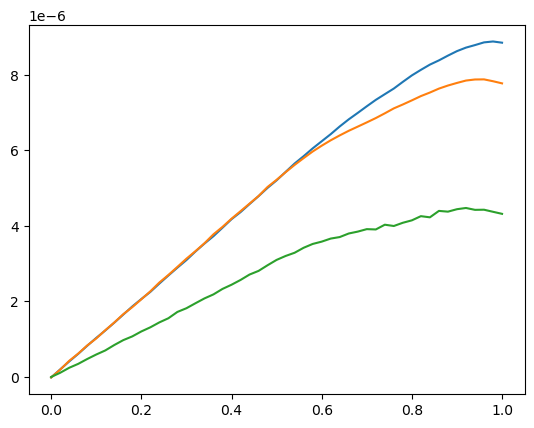

In [53]:
zero_datas_aver = [np.average(data) for data in zero_datas]
one_datas_aver = [np.average(data) for data in one_datas]
two_datas_aver = [np.average(data) for data in two_datas]
plt.plot(meas_amp_list, np.imag(np.array(zero_datas_aver)))
plt.plot(meas_amp_list, np.imag(np.array(one_datas_aver)))
plt.plot(meas_amp_list, np.imag(np.array(two_datas_aver)))

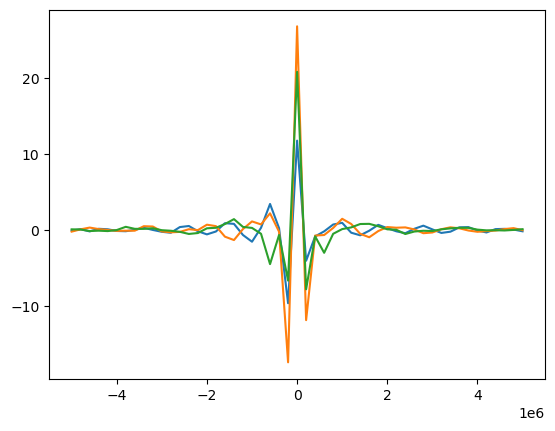

In [52]:
plt.plot(shift_frequencies, np.imag(np.array(zero_datas_aver)))
plt.plot(shift_frequencies, np.imag(np.array(one_datas_aver)))
plt.plot(shift_frequencies, np.imag(np.array(two_datas_aver)))

In [22]:
zero_datas_reshaped = [reshape_complex_vec(zero_datas[i]) for i in range(51)]
one_datas_reshaped = [reshape_complex_vec(one_datas[i]) for i in range(51)]
two_datas_reshaped = [reshape_complex_vec(two_datas[i]) for i in range(51)]

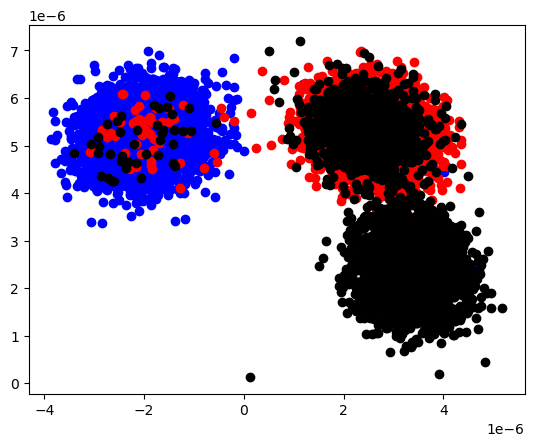

In [49]:
plt.scatter(zero_datas_reshaped[25][:, 0], zero_datas_reshaped[25][:, 1], color='blue', label='0')
plt.scatter(one_datas_reshaped[25][:, 0], one_datas_reshaped[25][:, 1], color='red', label='1')
plt.scatter(two_datas_reshaped[25][:, 0], two_datas_reshaped[25][:, 1], color='black', label='2')

In [57]:
discrimination_data = [[datas_single[0][i], datas_single[1][i], datas_single[2][i]] for i in range(len(datas_single[0]))]

In [61]:
len(discrimination_data)

51

In [60]:
def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    score = LDA_012.score(IQ_012_test, state_012_test)
    return LDA_012, score

In [62]:
2048*2

4096

In [69]:
NUM_SHOTS = 4096
confusion_matrices = []
scores = []
for data in discrimination_data:
    LDA_012, score = discriminate(data)
    count_data = count(data, LDA_012)
    conf_mat = np.array([[count_data[i]['0'] / NUM_SHOTS, count_data[i]['1'] / NUM_SHOTS, count_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(count_data)[0])])
    scores.append(score)
    confusion_matrices.append(conf_mat)

In [77]:
np.trace(confusion_matrices[0])

1.009521484375

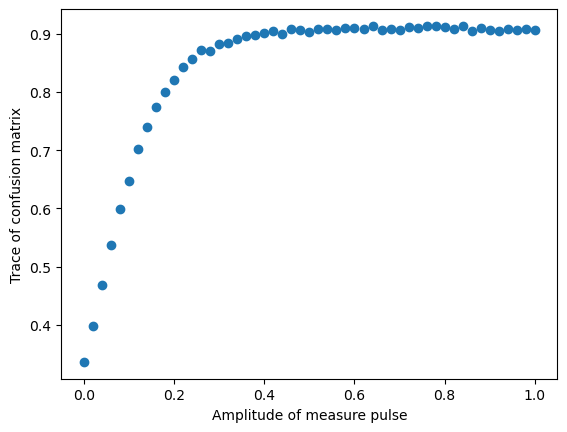

In [81]:
plt.scatter(meas_amp_list, [np.trace(confusion_matrices[i])/3 for i in range(len(confusion_matrices))])
plt.xlabel("Amplitude of measure pulse")
plt.ylabel("Trace of confusion matrix")
plt.savefig("trace_conf_mat_meas_discriminator_11_29_2023")

Text(0, 0.5, 'Score of LDA on test set')

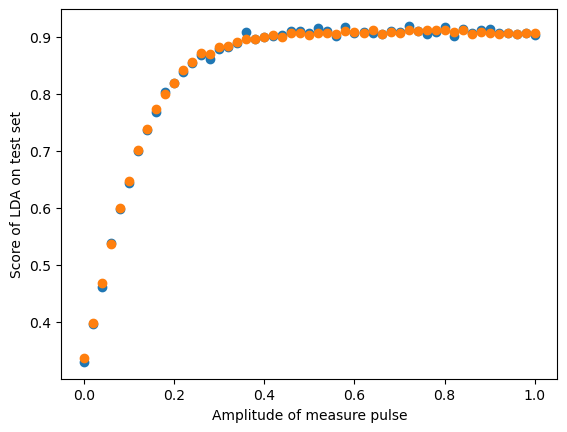

In [82]:
plt.scatter(meas_amp_list, scores)
plt.scatter(meas_amp_list, [np.trace(confusion_matrices[i])/3 for i in range(len(confusion_matrices))])
plt.xlabel("Amplitude of measure pulse")
plt.ylabel("Score of LDA on test set")
#plt.savefig("amp_meas_discriminator_11_29_2023")

In [71]:
confusion_matrices

[array([[0.26049805, 0.31958008, 0.41992188],
        [0.26879883, 0.32275391, 0.40844727],
        [0.26489258, 0.30883789, 0.42626953]]),
 array([[0.51708984, 0.22241211, 0.26049805],
        [0.37646484, 0.27880859, 0.34472656],
        [0.34692383, 0.25317383, 0.39990234]]),
 array([[0.57397461, 0.20874023, 0.21728516],
        [0.30053711, 0.34643555, 0.35302734],
        [0.25463867, 0.26000977, 0.48535156]]),
 array([[0.6628418 , 0.17431641, 0.1628418 ],
        [0.27270508, 0.39868164, 0.32861328],
        [0.18994141, 0.26000977, 0.55004883]]),
 array([[0.73510742, 0.15209961, 0.11279297],
        [0.21118164, 0.4699707 , 0.31884766],
        [0.14599609, 0.26025391, 0.59375   ]]),
 array([[0.80078125, 0.12646484, 0.07275391],
        [0.17871094, 0.52294922, 0.29833984],
        [0.10791016, 0.27490234, 0.6171875 ]]),
 array([[0.84985352, 0.10083008, 0.04931641],
        [0.14013672, 0.59301758, 0.2668457 ],
        [0.08129883, 0.25683594, 0.66186523]]),
 array([[0.87988281,

In [64]:
scores

[0.3268239761323569,
 0.4030377000271223,
 0.457011120151885,
 0.5364795226471386,
 0.5888256034716571,
 0.6465961486303228,
 0.7046379170056957,
 0.7263357743422837,
 0.7724437211825332,
 0.8060754000542446,
 0.8207214537564416,
 0.842690534309737,
 0.8516409004610794,
 0.8725250881475455,
 0.864388391646325,
 0.8803905614320586,
 0.8803905614320586,
 0.8963927312177923,
 0.9045294277190128,
 0.8925956061838893,
 0.903173311635476,
 0.9077841063195009,
 0.9064279902359642,
 0.9029020884187686,
 0.9066992134526716,
 0.9061567670192568,
 0.8999186330349878,
 0.9039869812855981,
 0.9015459723352319,
 0.9088689991863304,
 0.9050718741524274,
 0.9088689991863304,
 0.9104963384865744,
 0.9058855438025495,
 0.9096826688364524,
 0.9075128831027935,
 0.9167344724708435,
 0.9096826688364524,
 0.9153783563873068,
 0.910225115269867,
 0.9189042582045023,
 0.9069704366693789,
 0.910225115269867,
 0.903173311635476,
 0.9091402224030377,
 0.9056143205858421,
 0.9075128831027935,
 0.9091402224030377,

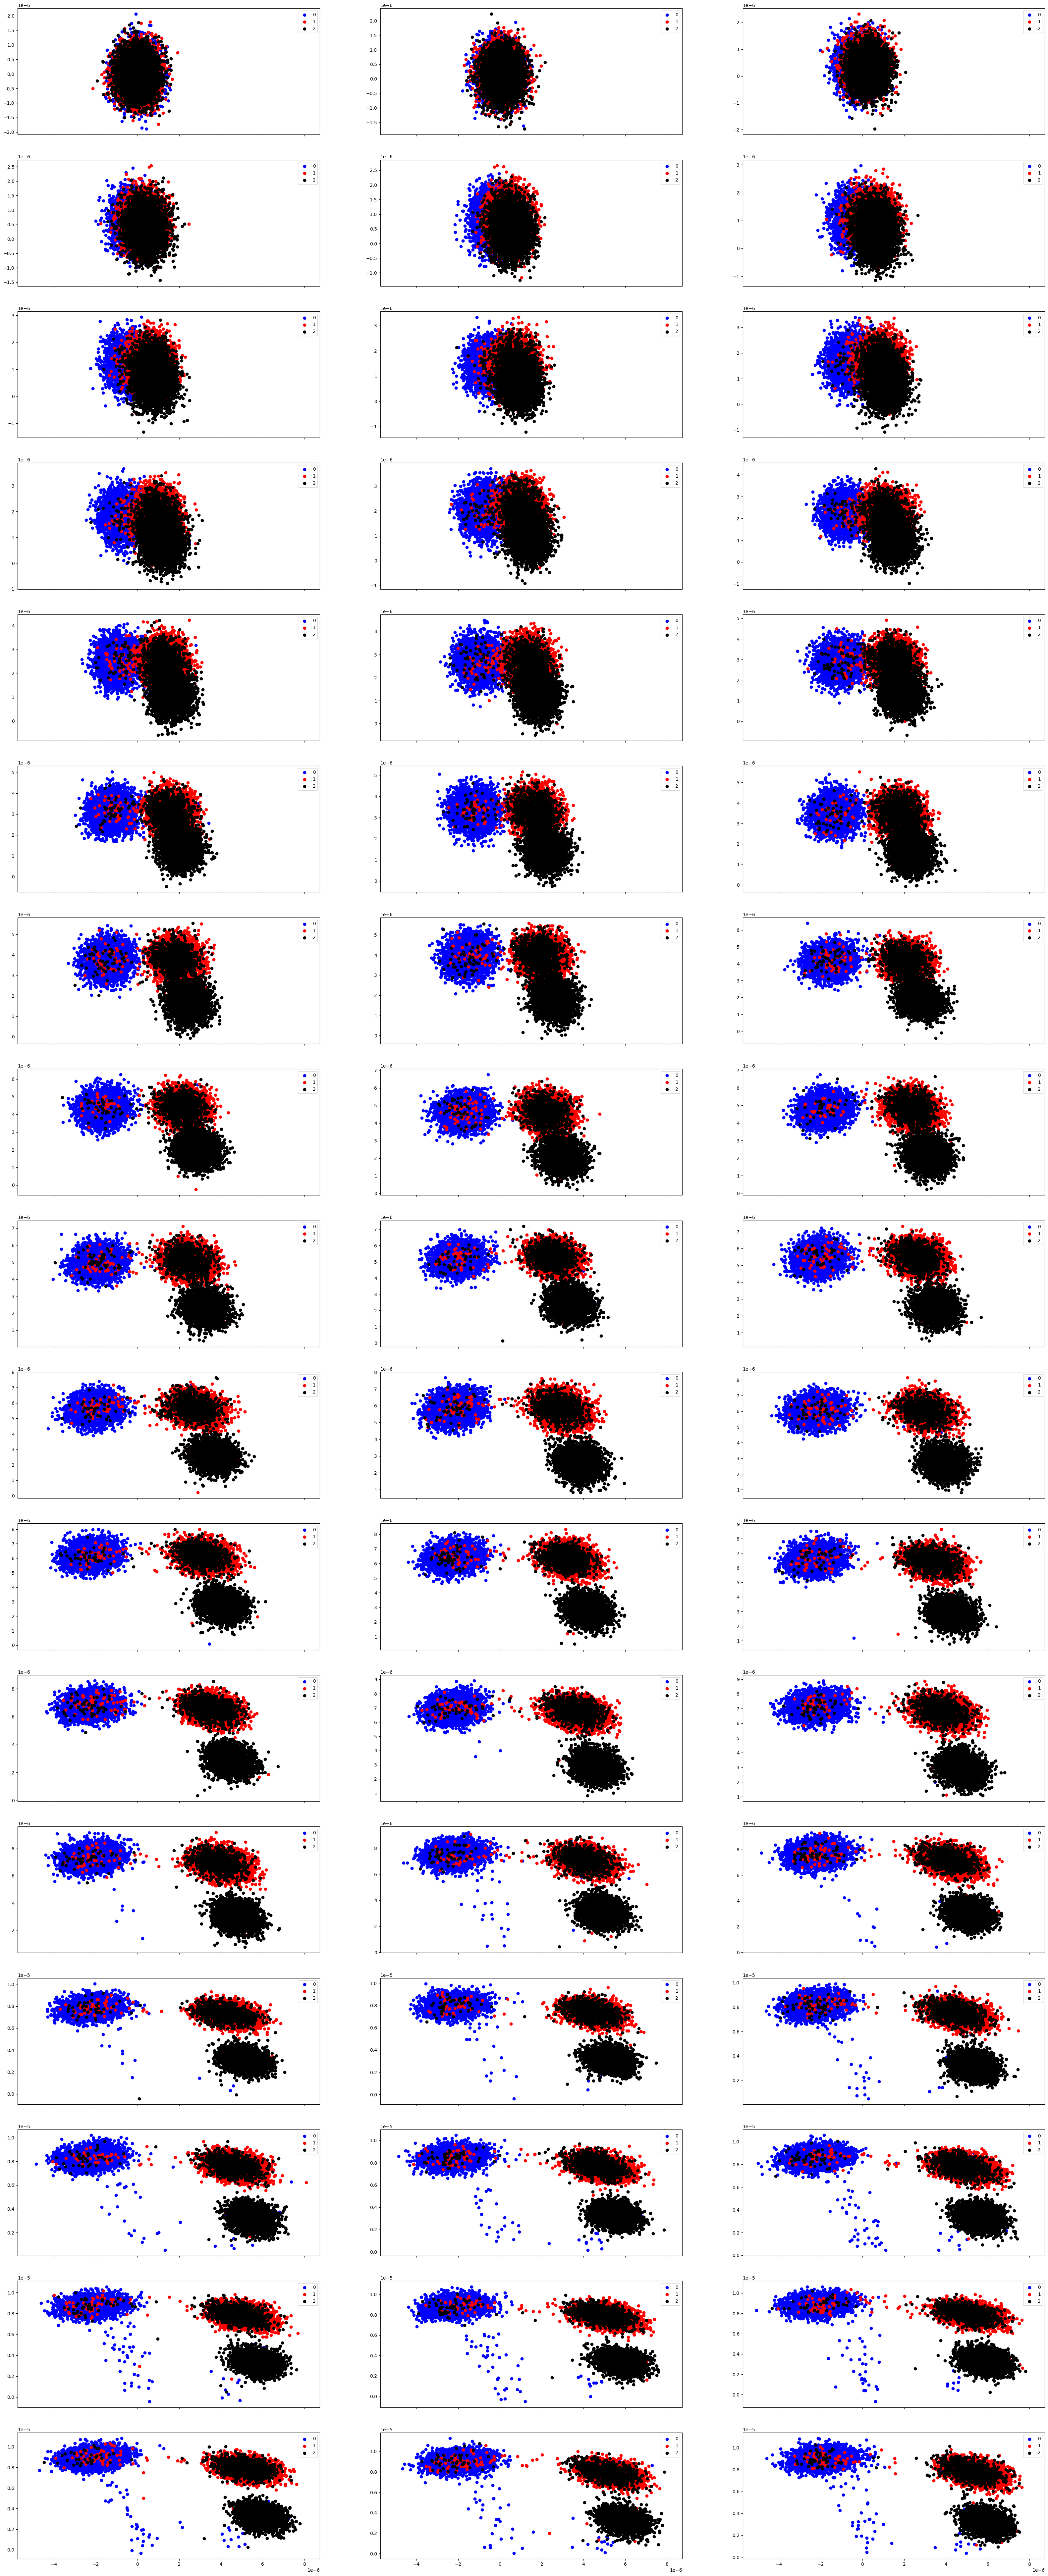

In [23]:
fig, axs = plt.subplots(nrows=17, ncols=3, sharex=True, figsize=(40, 100))
for i in range(17):
    for j in range(3):
        index = 3*i + j
        axs[i][j].scatter(zero_datas_reshaped[index][:, 0], zero_datas_reshaped[index][:, 1], color='blue', label='0')
        axs[i][j].scatter(one_datas_reshaped[index][:, 0], one_datas_reshaped[index][:, 1], color='red', label='1')
        axs[i][j].scatter(two_datas_reshaped[index][:, 0], two_datas_reshaped[index][:, 1], color='black', label='2')
        axs[i][j].legend()
        #axs[i][j].set_title(np.round(shift_frequencies_MHz[index], 1))

In [41]:
shift_frequencies_MHz = shift_frequencies/MHz

In [58]:
fig.savefig("IQ_plane_meas_ams_spec_0_1_2")

In [ ]:
0 0 1 2
1 0 1 2
2 0 1 2 

In [46]:
def IQ_012_plot(x_min, x_max, y_min, y_max, data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)


In [63]:
job = provider.backend.retrieve_job("cnc8fxqp253000870ed0")
data = get_job_data(job, average=True)

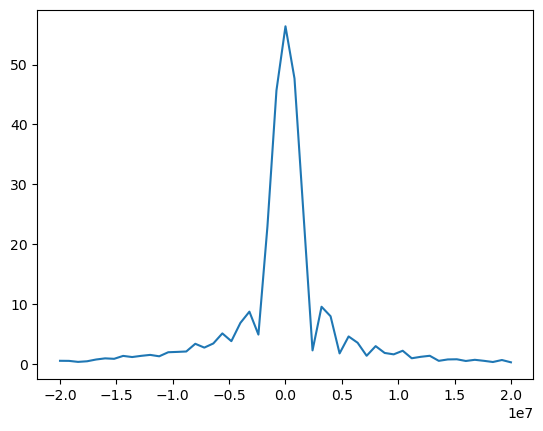

In [65]:
plt.plot(shift_frequencies, data)

In [41]:
job_monitor(job)

Job Status: job has successfully run
